# Exploring Sparse Coding

## Intro

* **Date**: 12/11/2020
* **What**: I'm going to be implementing perhaps several variants of sparse coding.
* **Why**: I thought Krotov and Hopfield's network was state of the art.  Turns out that's a 70 year old architecture.  Kinda amazing it was even published.  Sparse coding seems to do a lot of what I wanted with winner-takes-all, but without being dumb and only updating one neuron per iteration.
* **Hopes**: I want a network that's able to build effectively reconstruct its input based on statistical structure, but is sparse, so I hopefully won't get the pixel-like weight prototypes I was getting with the collaborative, distinctly un-sparse, network.  
* **Limitations**: I haven't really worked with Sparse coding before, so I don't really know what's going to happen.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import expit as sigmoid
from tensorflow.keras.datasets import cifar10
from tqdm import tqdm

In [2]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

In [3]:
gray_train_x = np.linalg.norm(train_x, axis=3)
gray_test_x = np.linalg.norm(test_x, axis=3)

flat_x = gray_train_x.reshape(-1, 32 * 32)
flat_test = gray_test_x.reshape(-1, 32 * 32)

flat_x /= np.max(flat_x, axis=1).reshape(-1, 1)
flat_test /= np.max(flat_test, axis=1).reshape(-1, 1)

L, S = flat_x.shape

In [4]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Kx, s_len * Ky))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


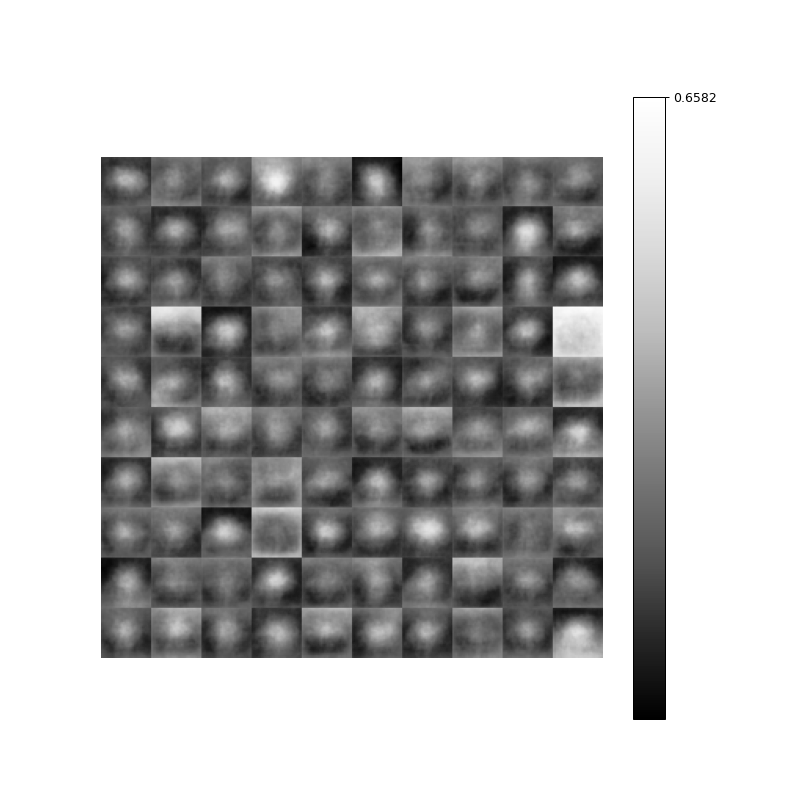

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 535.52it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 479.92it/s]


In [58]:
%matplotlib notebook
# %matplotlib inline
fig = plt.figure(figsize=(10, 10))

Nep = 50
T_s = 1000
Kx = 10
Ky = 10

s = 0.05
s2 = s * s

a = 0.01
b = 0.01
g = 0.01

N = Kx * Ky



w = np.abs(np.random.normal(0, 1, (N, S)))
w /= np.max(w)

c_i = np.abs(np.random.normal(0, 1, (N, N)))
c_i /= np.max(c_i)

np.fill_diagonal(c_i, 0)

t = np.zeros((N, 1))

for ep in range(Nep):
    inputs = flat_x[np.random.permutation(L)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(1, -1)
        p = w @ v.T
        r = (c_i @ p) + p
        y = sigmoid(r - t)
        
        w += b * (y * (v - w))
        t += g * (y - s)
        c_i += -a * ((y * y.T) - s2)
        np.fill_diagonal(c_i, 0)
        
    draw_weights(w, Kx, Ky, fig)
        
        

## Analysis Dialog

Well, that was weird, but I guess somewhat expected.  Basically, this bad boi is *super super* under-complete.  Also it's taking about two minutes to train with 100 neurons.  Big yikes.  Sooo, I'm going to just take like a 10x10 from the centers of the images to make sure we're groovy.

In [6]:
S = 10
S2 = S // 2

sm_flat_x = gray_train_x[:, 16-S2:16+S2, 16-S2:16+S2].reshape(-1, S * S)

sm_flat_x /= np.max(sm_flat_x)

<IPython.core.display.Javascript object>


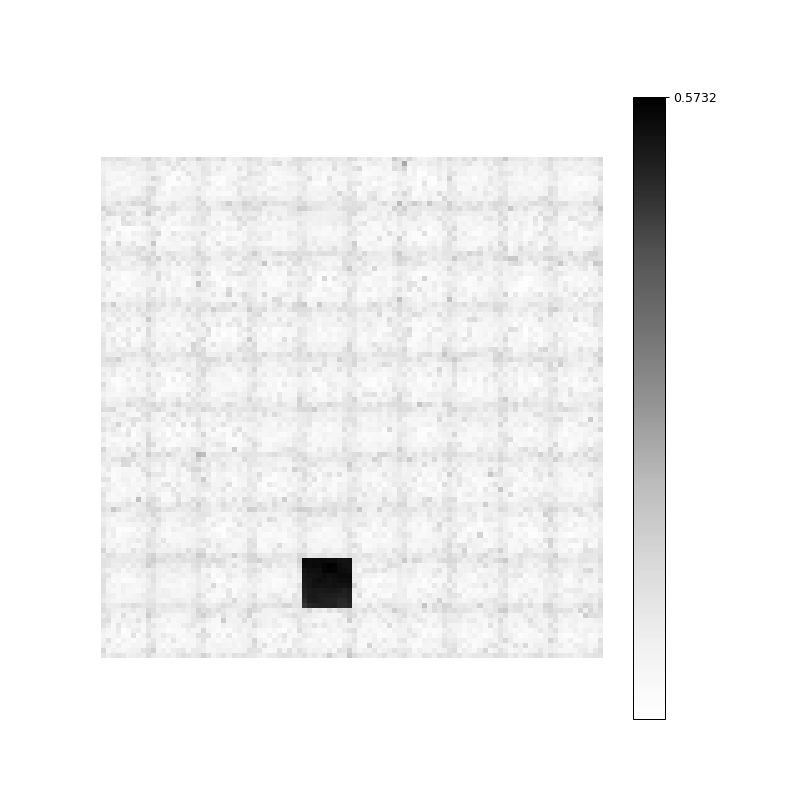

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3637.77it/s]


In [81]:
%matplotlib notebook
# %matplotlib inline
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10000
Kx = 10
Ky = 10

s = 0.05
s2 = s * s

a = 0.01
b = 0.01
g = 0.01

N = Kx * Ky


w = np.abs(np.random.normal(0, 1, (N, S * S)))
w /= np.max(w)

c_i = np.abs(np.random.normal(0, 1, (N, N)))
c_i /= -np.max(c_i)

np.fill_diagonal(c_i, 0)

t = np.zeros((N, 1))

for ep in range(Nep):
    inputs = sm_flat_x[np.random.permutation(L)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(1, -1)
        p = w @ v.T
        r = (c_i @ p) + p
        y = sigmoid(r - t)
        
        w += b * (y * (v - w))
        t += g * (y - s)
        c_i += -a * ((y * y.T) - s2)
        np.fill_diagonal(c_i, 0)
        
    draw_weights(w, Kx, Ky, S, fig)
     

Well that looks like there's probably something very broken about the code.  I'm going to try to figure out what's happening.

<IPython.core.display.Javascript object>


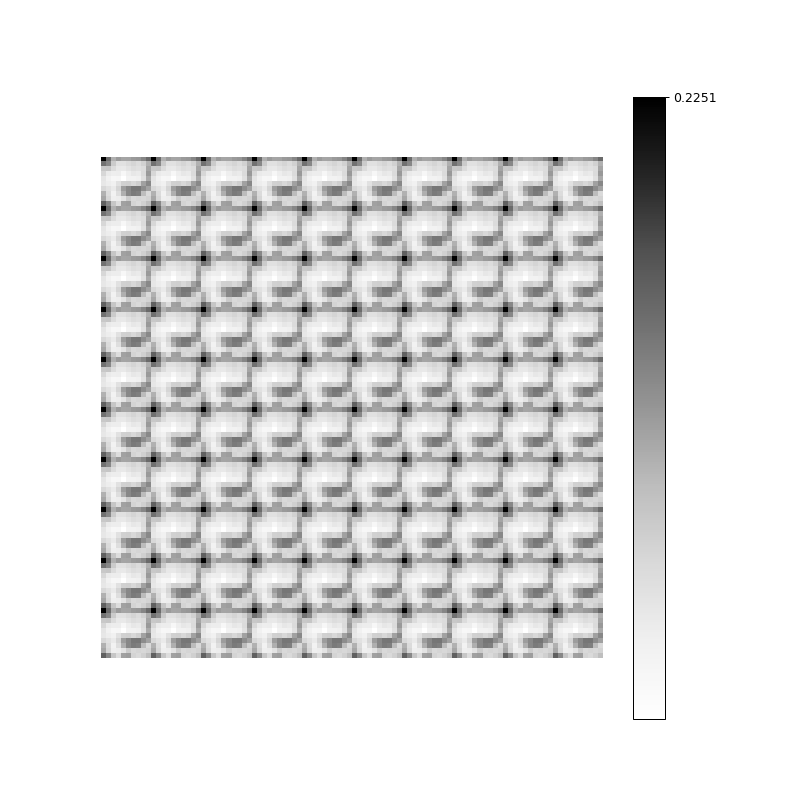

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3543.56it/s]


In [27]:
%matplotlib notebook
# %matplotlib inline
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10000
Kx = 10
Ky = 10

s = 0.05
s2 = s * s

a = 0.001
b = 0.1
g = 0.01

N = Kx * Ky


w = np.random.uniform(0, 10, (N, S * S))

# c_i = -np.random.uniform(0, 10, (N, N))
c_i = np.zeros((N, N))


np.fill_diagonal(c_i, 0)

t = np.zeros((N, 1))

for ep in range(Nep):
    inputs = sm_flat_x[np.random.permutation(L)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(1, -1)
        p = w @ v.T
        r = (c_i @ p) + p
        y = sigmoid(r - t)
        
#         print(b * (y * (v - w)))
        
        w += b * (y * (v - w))
        t += g * (y - s)
        c_i += -a * ((y * y.T) - s2)
        np.fill_diagonal(c_i, 0)
        
    draw_weights(w, Kx, Ky, S, fig)
     

Well, this is incredibly irritating.  Basically nothing sparse whatsoever is happening.  

That being said, I think the sparsity factor is still pretty juicy.  

I think I know what I have to do.  Remember the collaborative auto-encoder?  Yeah, we're about to give him a glow up.

## Conclusions

Peter Foldiak is a lying son of a gun.  That's all.

Just kidding.  But I think his network is straight-up bad if it's only trying to do analysis.  We need synthesis, baby.  To use some fairly imprecise language, it doesn't look like the weight prototypes are at all anchoring themselves to the inputs.  

Yeah, it's just straight-up not good.  I thought sparsity would save everything, but it simply doesn't.  Also the motif of "Danny treats all the neurons the same every loop, and the neurons all do the same thing" is really happening here.  I think perhaps the only way to get around that is if you're literally updating synapses based on reconstruction only.  Otherwise, the sort of feed-forward "blind analysis" just converges to the same stuff.  Good that we got that sorted out.

## Next steps

Redo the collaborative auto-encoder, but this time build in the sparsity factor.  I think it might just purr like a fracking cat.  By that, I mean it might just learn a bunch of good, sparse features.
